In [1]:
import numpy as np
from TransportMaps.Distributions.Examples import ScalarLinearGaussMarkovProcess as GMP
from TransportMaps.Algorithms import SequentialInference as ALGSI
import TransportMaps.Distributions as DIST
import TransportMaps.Diagnostics as DIAG
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.size'] = 15

# Scalar Gauss-Markov process

We consider the state-space model

$$
Z_{k} = \phi Z_{k-1} + w_k \;, \quad w_k\sim\mathcal{N}(0,Q_k)\;, \\
Y_k = H Z_k + v_k \;, \quad v_k\sim\mathcal{N}(0,R_k)\;, \\
Z_0 \sim \mathcal{N}(0,1)\;,
$$

where $\phi=\exp(-0.02)$, $Q_k=\exp(-0.04)$, $H=1$ and $R_k=1$.

In [2]:
def plot_dynamics_data(T,Z,Y):
    plt.figure(figsize=(10,5))
    plt.subplot(121); plt.plot(T,Z[0,:]); plt.ylabel(r"$z$"); plt.xlabel("T [s]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
    y1 = [y[0] if y is not None else None for y in Y]
    plt.subplot(122); plt.plot(T,y1,'.'); plt.ylabel(r"$y$"); plt.xlabel("T [h]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
    plt.tight_layout()

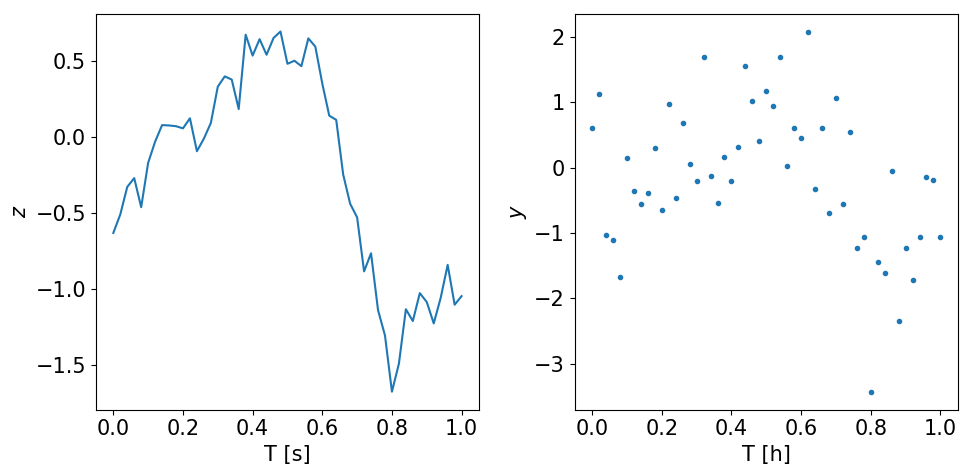

In [3]:
nsteps = 50
T,Z,Y = GMP.generate_data(nsteps)
plot_dynamics_data(T,Z,Y);

## Kalman filter

In [4]:
pi_prior = GMP.Prior()
pi_trans = GMP.Transition()
FLT = ALGSI.LinearSequentialFilter()
for n in range(nsteps+1):
    # Define log-likelihood
    if Y[n] is None: # Missing data
        ll = None
    else: 
        ll = GMP.LogLikelihood(Y[n])
    # Define transition / prior
    if n > 0: 
        pin = pi_trans
    else:
        pin = pi_prior
    # Assimilation
    print("%3d" % n, end="")
    FLT.assimilate(pin, ll)

  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50

In [5]:
def plot_dynamics_vs_tracks(T,Z,M,V):
    plt.figure(figsize=(6,5))
    plt.plot(T,Z[0,:]);
    plt.plot(T,M,'k-');
    conf = 1.96 * np.sqrt(V)
    plt.fill_between(T,M-conf,M+conf,color='r',alpha=0.3)
    plt.ylabel(r"$z$"); plt.xlabel("T [s]"); plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));
    plt.tight_layout()

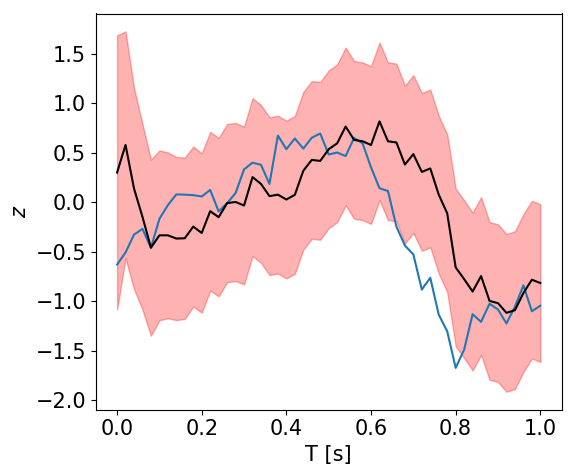

In [6]:
mean_list = FLT.get_filtering_mean_list()
cov_list = FLT.get_filtering_covariance_list()
mean = [m[0] for m in mean_list]
var = [cov[0,0] for cov in cov_list]
plot_dynamics_vs_tracks(T,Z,mean,var)

## Linear smoother

In [7]:
SMT = ALGSI.LinearSequentialSmoother()
for n in range(nsteps+1):
    # Define log-likelihood
    if Y[n] is None: # Missing data
        ll = None
    else: 
        ll = GMP.LogLikelihood(Y[n])
    # Define transition / prior
    if n > 0: 
        pin = pi_trans
    else:
        pin = pi_prior
    # Assimilation
    print("%3d" % n, end="")
    SMT.assimilate(pin, ll)

  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50

In [8]:
M = SMT.get_smoothing_map()
pi = SMT.pi
pull_M_pi = DIST.PullBackTransportMapDistribution(M, pi)
rho = DIST.StandardNormalDistribution(pi.dim)
var_seq = DIAG.variance_approx_kl(rho, pull_M_pi, qtype=0, qparams=1000)
print("Variance diagnostic - Sequential: %e" % var_seq)

Variance diagnostic - Sequential: 3.870341e-27


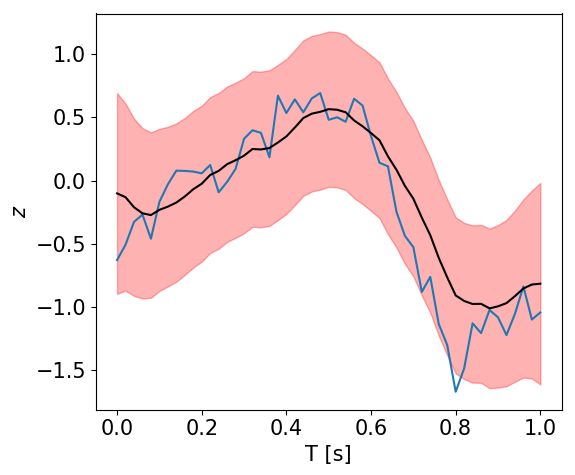

In [9]:
push_M_rho = DIST.PushForwardTransportMapDistribution(M, rho)
samps = push_M_rho.rvs(100000)
mean = np.mean(samps,axis=0)
var = np.var(samps,axis=0)
plot_dynamics_vs_tracks(T,Z,mean,var)